# Quickstart

## Evaluating the performance of a hybrid power plant using HyDesign

In this notebook we will evaluate a simplified hybrid power plant design in a specific location.

A simplified hybrid power plant design consists on selecting the following parameters:

**Wind Plant design:**

1. Number of wind turbines in the wind plant [-] (`Nwt`)
2. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

3. Solar plant power capacity [MW] (`solar_MW`)

**Battery Storage design:**

4. Battery power [MW] (`b_P`)
5. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
6. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.


##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0)
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/input_ts_Indian_site_bad_solar_bad_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W


select a site to run

In [5]:
name = 'France_good_wind'
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

##

**Input data: weather and electricity price**

For each site a csv input file is provided. This file contains the weather and the spot market electricity prices.

The columns required are:

* Wind speed at multiple heights (`WS_hh`, where hh is the height in meters). In order to estimate the PV cell temperature, it is important to have a wind speed close to the ground (`WS_1`). 

* (optional) Wind direction at multiple heights (`WD_hh`, where hh is the height in meters). Wind directions can be used when the layout of the wind farm is known and therefore the wind generation depends on the wind direction.  

* Air temperature in Kelvin close to the ground (`temp_air_1`)

* Global horizontal irradiance (`ghi`).

* Direct normal irradiance (`dni`).

* Diffuse horizontal irradiance (`dhi`).

* Spot market electricity prices (`Price`)


In [6]:
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

input_ts = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)

required_cols = [col for col in input_ts.columns if 'WD' not in col]
input_ts = input_ts.loc[:,required_cols]
input_ts

,WS_1,WS_50,WS_100,WS_150,WS_200,temp_air_1,ghi,dni,dhi,Price
2012-01-01 00:00:00,3.816262,9.189450,11.084209,12.271178,13.193283,284.873662,0.10670,0.0,0.10670,32.685
2012-01-01 01:00:00,3.433942,8.425198,10.193588,11.295483,12.177159,284.759079,0.05335,0.0,0.05335,32.685
2012-01-01 02:00:00,3.401840,8.457382,10.257751,11.500057,12.475967,284.682409,0.00000,0.0,0.00000,32.685
2012-01-01 03:00:00,3.552851,8.750878,10.595812,11.846432,12.862474,284.804835,0.00000,0.0,0.00000,32.685
2012-01-01 04:00:00,3.563602,8.849321,10.730704,12.023872,13.075707,284.912742,0.00000,0.0,0.00000,32.685
...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,5.254660,12.403092,14.906025,15.135357,16.764699,281.919356,0.00000,0.0,0.00000,37.591
2012-12-31 20:00:00,4.820323,11.405330,13.714530,13.932132,15.532491,281.790435,0.00000,0.0,0.00000,35.839
2012-12-31 21:00:00,4.138561,9.976792,12.031371,12.443978,14.001972,281.700990,0.00000,0.0,0.00000,35.362
2012-12-31 22:00:00,3.034242,7.610207,9.245204,9.726618,11.033008,281.499113,0.00000,0.0,0.00000,34.468


##
**Additional data**

Each region has a different hybrid power plant evaluation parameter file (`hpp_pars.yml`).
This file contains all the assumptions on the valuation of a hyrbid power plant. 

In the examples, the Indian sites have specified a requiredment to provide power at peak hours. This requirement is specified by setting the minimum number of full power hours at peak prices times per day. 

For example the Indian case penalty has expected hours of `0.85*3= 2.55`:


`n_full_power_hours_expected_per_day_at_peak_price: 2.55`


While the Europe sites have no penalty.

`n_full_power_hours_expected_per_day_at_peak_price: 0`

In [7]:
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]

with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)

print(sim_pars_fn)    
sim_pars

c:/sandbox/repo/topfarm/hydesign/hydesign/examples/Europe/hpp_pars.yml


{'G_MW': 300,
 'year': '2012',
 'N_life': 25,
 'wind_turbine_cost': 640000,
 'wind_civil_works_cost': 260000,
 'wind_fixed_onm_cost': 12600,
 'wind_variable_onm_cost': 1.35,
 'wpp_efficiency': 1.0,
 'd_ref': 145,
 'hh_ref': 100,
 'p_rated_ref': 5.0,
 'solar_PV_cost': 110000,
 'solar_hardware_installation_cost': 100000,
 'solar_inverter_cost': 20000,
 'solar_fixed_onm_cost': 4500,
 'pv_deg_per_year': 0.005,
 'land_use_per_solar_MW': 0.01226,
 'tracking': 'No',
 'battery_energy_cost': 90000,
 'battery_power_cost': 32000,
 'battery_BOP_installation_commissioning_cost': 36000,
 'battery_control_system_cost': 9000,
 'battery_energy_onm_cost': 0,
 'battery_depth_of_discharge': 0.9,
 'battery_charge_efficiency': 0.98,
 'battery_price_reduction_per_year': 0.1,
 'peak_hr_quantile': 0.9,
 'n_steps_in_LoH': 20,
 'min_LoH': 0.7,
 'n_full_power_hours_expected_per_day_at_peak_price': 0,
 'price_H2': 5,
 'storage_eff': 1,
 'ptg_deg': 0.99,
 'hhv': 39.3,
 'water_consumption': 9.4,
 'electrolyzer_capex

##
**Wind Turbine parameters:**

1. Hub height [m] 
2. Rotor diameters [m]
3. Rated power of the wind turbine [MW] (`p_rated`)

**PV parameters:**

4. Surface tilt [deg] (`surface_tilt`)
5. Surface azimuth [deg] (`surface_azimuth`)
6. DC-AC ratio [-] (`solar_DCAC`): This parameter controls how much over-planting of PV (in DC power) is connected to the inverters. It is common practice in PV design to have `solar_DCAC = 1.5`. 

In [8]:
rotor_diameter_m = 220
hub_height_m = 130
wt_rated_power_MW = 10
surface_tilt_deg = 35
surface_azimuth_deg = 180
DC_AC_ratio = 1.5


## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [10]:
hpp = hpp_model(
        latitude,
        longitude,
        altitude,
        rotor_diameter_m = rotor_diameter_m,
        hub_height_m = hub_height_m,
        wt_rated_power_MW = wt_rated_power_MW,
        surface_tilt_deg = surface_tilt_deg,
        surface_azimuth_deg = surface_azimuth_deg,
        DC_AC_ratio = DC_AC_ratio,
        num_batteries = 1,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
)


Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0


### Extract data from DTU's ERA5 database

In [11]:
# price_fn = examples_filepath+ex_site['price_fn'].values[0]
# price = pd.read_csv(price_fn,index_col=0, parse_dates=True)[ex_site.price_col.values[0]]

# hpp = hpp_model_simple(
#         latitude,
#         longitude,
#         altitude,
#         rotor_diameter_m = rotor_diameter_m,
#         hub_height_m = hub_height_m,
#         wt_rated_power_MW = wt_rated_power_MW,
#         surface_tilt_deg = surface_tilt_deg,
#         surface_azimuth_deg = surface_azimuth_deg,
#         DC_AC_ratio = DC_AC_ratio,
#         num_batteries = 1,
#         work_dir = './',
#         sim_pars_fn = sim_pars_fn,
#         input_ts_fn=None,
#         price_fn=price,
# )

##
### Evaluating the HPP model

In [12]:
start = time.time()

Nwt = 20
wind_MW_per_km2 = 7
solar_MW = 150
b_P = 20
b_E_h  = 3
cost_of_batt_degr = 5
clearance = hub_height_m - rotor_diameter_m / 2
sp = 4 * wt_rated_power_MW * 10 ** 6 / np.pi / rotor_diameter_m ** 2

x = [# Wind plant design
    clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    # PV plant design
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    # Energy storage & EMS price constrains
    b_P, b_E_h, cost_of_batt_degr]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 20.000
sp [W/m2]: 263.066
p_rated [MW]: 10.000
Nwt: 20.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 150.000
surface_tilt [deg]: 35.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 20.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 5.000


NPV_over_CAPEX: 0.001
NPV [MEuro]: 0.489
IRR: 0.054
LCOE [Euro/MWh]: 29.006
CAPEX [MEuro]: 339.145
OPEX [MEuro]: 4.063
Wind CAPEX [MEuro]: 222.901
Wind OPEX [MEuro]: 3.050
PV CAPEX [MEuro]: 49.750
PV OPEX [MEuro]: 1.012
Batt CAPEX [MEuro]: 6.940
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 59.553
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 995.987
GUF: 0.379
grid [MW]: 300.000
wind [MW]: 200.000
solar [MW]: 150.000
Battery Energy [MWh]: 60.000
Battery Power [MW]: 20.000
Total curtailment [GWh]: 23.051
Awpp [km2]: 28.571
Apvp [km2]: 1.839
Rotor diam [m]: 220.000
Hub height [m]: 130.000
Number of batteries used in lifetime: 1.000

exec. time [min]:

##
### Understanding the sub-models

Plot an interactive N2 diagram (or N-squared diagram) to explore all components and interfaces between system elements. 

Hydesign consists of several submodels:

**Wind turbines/plant:**

- genericWT: generic wind turbine model
- genericWake: generic wake losses model
- wpp: wind power plant
- wpp_cost: wind power plant cost model

**PV plant:**

- pvp: PV power plant
- pvp_degradation_linear: PV degradation model
- pvp_cost: PV power plant cost model

**Battery:**

- battery_degradation: Battery degradation model
- battery_cost: Battery cost model

**HPP operation**

- ems: (Energy Management System) Idealized hpp operation design. This component optimizes the operation of a HPP without considering degradation (PV nor Battery).
- ems_long_term_operation: This component executes the hpp operation changes in expected generation profiles and/or degradation on battery. This component tries to follow the operation plan (results of ems). 

**HPP**

- shared_costs: Shared HPP infrastructure cost model
- finance: HPP financial performance metrics model





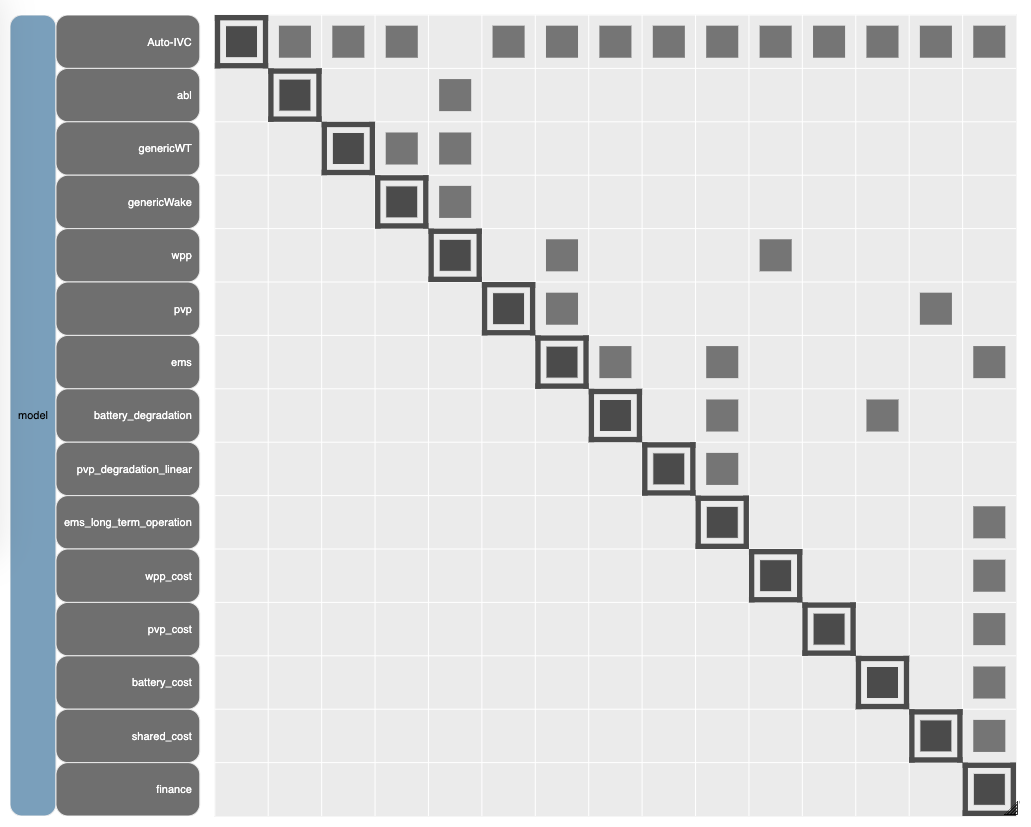

In [13]:
from openmdao.visualization.n2_viewer.n2_viewer import n2
#n2(hpp.prob) ## execute to generate an interactive diagram 

# Static view
from IPython import display
display.Image("./n2.png")

##
### Plot the HPP operation

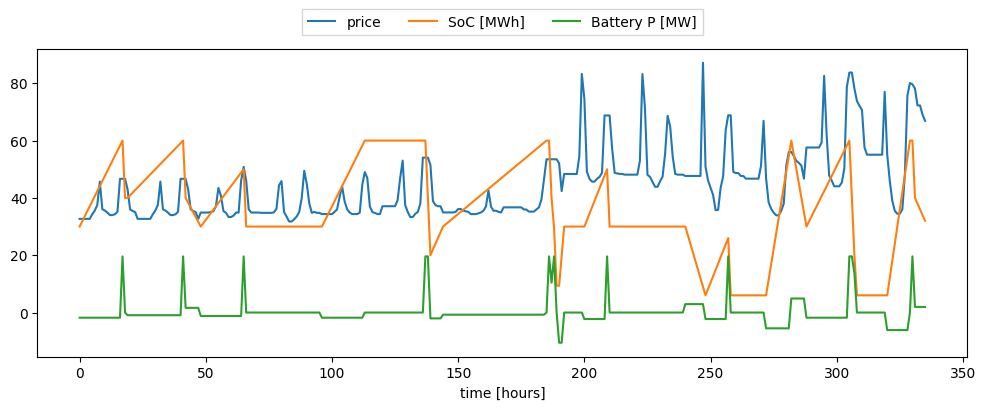

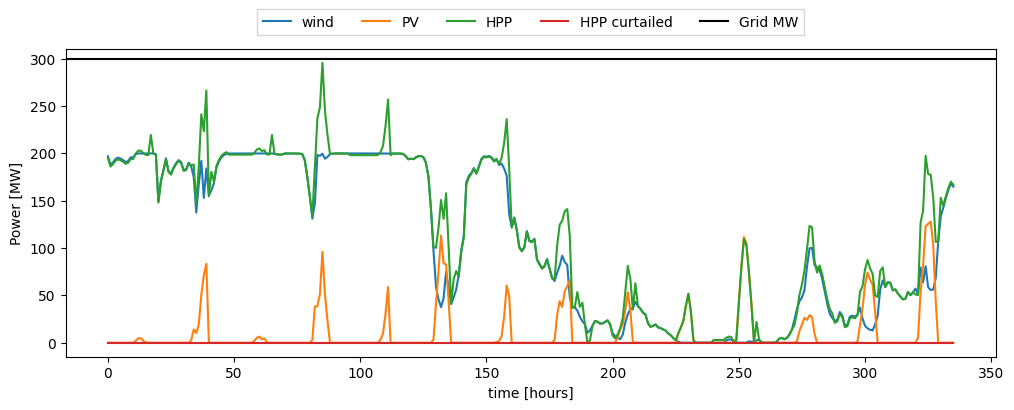

In [14]:
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
grid_MW = hpp.prob.get_val('ems.G_MW')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)


##
### Plot the battery degradation

Battery degradation is modeled as steps of constant health in order to simplify the actual operation with degradation for the lifetime of the project.

Text(0, 0.5, 'Battery State of Health [-]')

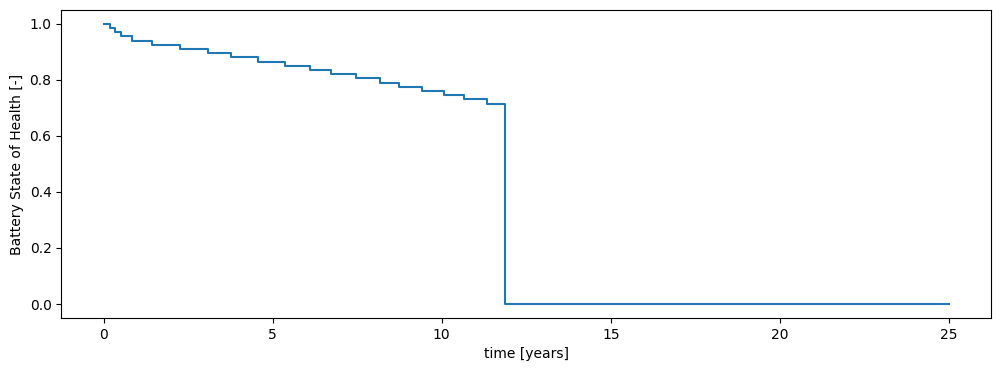

In [15]:
ii_time = hpp.prob.get_val('battery_degradation.ii_time')
SoH = hpp.prob.get_val('battery_degradation.SoH')

# append the last values at the end of the life for step ploting
ii_time_plot = np.append((ii_time/(365*24)),25)
SoH_plot = np.append(SoH,SoH[-1])

plt.figure(figsize=[12,4])
plt.step(ii_time_plot, SoH_plot, where='post')
plt.xlabel('time [years]')
plt.ylabel('Battery State of Health [-]')

##
### Compare ideal operation (ems) wit h actual long-term opertation with degradation

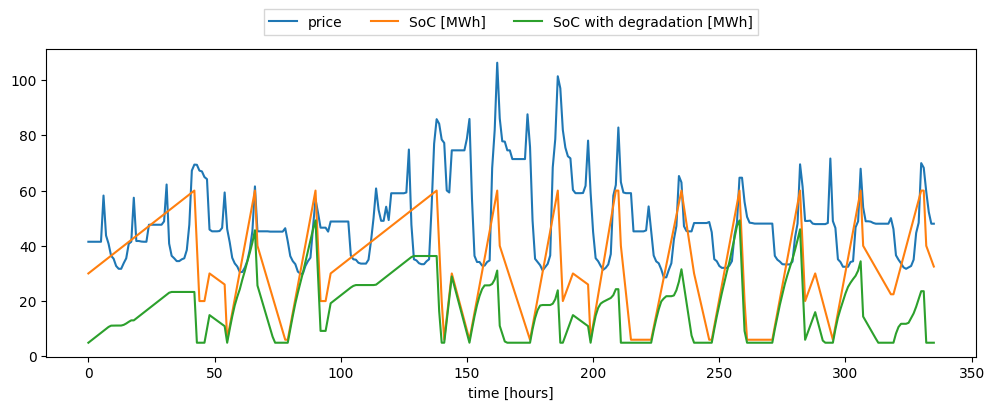

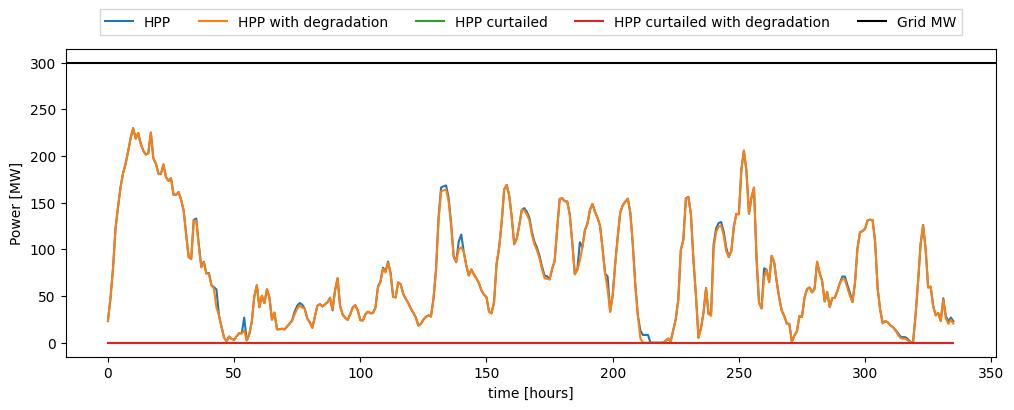

In [16]:
#solar_t = hpp.prob.get_val('ems.solar_t_ext')
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')

b_E_SOC_t_with_deg = hpp.prob.get_val('ems_long_term_operation.b_E_SOC_t_with_deg')
hpp_t_with_deg = hpp.prob.get_val('ems_long_term_operation.hpp_t_with_deg')
hpp_curt_t_with_deg = hpp.prob.get_val('ems_long_term_operation.hpp_curt_t_with_deg')

price_t_ext = hpp.prob.get_val('ems_long_term_operation.price_t_ext')

# Plot the HPP operation in the 7th year (with and without degradation)
n_start = int(24*365*7.2) 
n_days_plot = 14

plt.figure(figsize=[12,4])

plt.plot(price_t_ext[n_start:n_start+24*n_days_plot], label='price')
    
plt.plot(b_E_SOC_t[n_start:n_start+24*n_days_plot], label='SoC [MWh]')
plt.plot(b_E_SOC_t_with_deg[n_start:n_start+24*n_days_plot], label='SoC with degradation [MWh]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(hpp_t[n_start:n_start+24*n_days_plot], label='HPP')
plt.plot(hpp_t_with_deg[n_start:n_start+24*n_days_plot], label='HPP with degradation')

plt.plot(hpp_curt_t[n_start:n_start+24*n_days_plot], label='HPP curtailed')
plt.plot(hpp_curt_t_with_deg[n_start:n_start+24*n_days_plot], label='HPP curtailed with degradation')

plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=6, fancybox=0, shadow=0)


##
### Compare battery degradation results by changing the cost of battery fluctuations factor

In [17]:
cost_of_battery_P_fluct_in_peak_price_ratio = 0.0
x = [clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    b_P, b_E_h, cost_of_batt_degr]
outs = hpp.evaluate(*x)

ii_time = np.copy(hpp.prob.get_val('battery_degradation.ii_time'))
SoH = np.copy(hpp.prob.get_val('battery_degradation.SoH'))

cost_of_battery_P_fluct_in_peak_price_ratio = 1
x = [clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    b_P, b_E_h, cost_of_batt_degr]
outs = hpp.evaluate(*x)
ii_time_1 = np.copy(hpp.prob.get_val('battery_degradation.ii_time'))
SoH_1 = np.copy(hpp.prob.get_val('battery_degradation.SoH'))

cost_of_battery_P_fluct_in_peak_price_ratio = 5
x = [clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    b_P, b_E_h, cost_of_batt_degr]
outs = hpp.evaluate(*x)
ii_time_5 = np.copy(hpp.prob.get_val('battery_degradation.ii_time'))
SoH_5 = np.copy(hpp.prob.get_val('battery_degradation.SoH'))


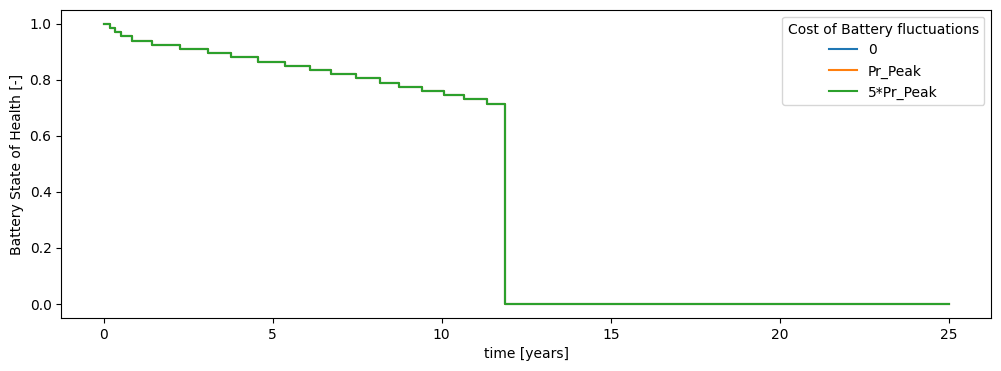

In [18]:
plt.figure(figsize=[12,4])
plt.step( np.append((ii_time/(365*24)),25), np.append(SoH,SoH[-1]), where='post', label='0')
plt.step( np.append((ii_time_1/(365*24)),25), np.append(SoH_1,SoH_1[-1]), where='post', label='Pr_Peak')
plt.step( np.append((ii_time_5/(365*24)),25), np.append(SoH_5,SoH_5[-1]), where='post', label='5*Pr_Peak')
plt.xlabel('time [years]')
plt.ylabel('Battery State of Health [-]')
plt.legend(title='Cost of Battery fluctuations')
print()
